In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error, depolarizing_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
class Alice:
    def __init__(self, bit_string, delta_t):
        self.bit_string = bit_string
        self.delta_t = delta_t

    def prepare_states(self):
        circuits = []
        for bit in self.bit_string:
            for _ in range(self.delta_t):
                # Initialize Quantum Circuit
                qr = QuantumRegister(2)
                cr = ClassicalRegister(2)
                qc = QuantumCircuit(qr, cr)
                # Prepare states
                if bit == '1':
                    qc.h(0) # Put first qubit in superposition
                    qc.cx(0, 1) # Apply CNOT to create entanglement
                # Measure state
                qc.measure(qr, cr)
                circuits.append(qc)
        return circuits

class Bob:
    def __init__(self, circuits, delta_t, noise_model, entanglement_ratio):
        self.circuits = circuits
        self.delta_t = delta_t
        self.backend = Aer.get_backend('qasm_simulator')
        self.noise_model = noise_model
        self.entanglement_ratio = entanglement_ratio
        self.bit_counts = {'00': 0, '01': 0, '10': 0, '11': 0}

        # print(f"11 - {self.bit_counts['11']}, 01 - {self.bit_counts['01']}, 10 - {self.bit_counts['10']}, 00 - {self.bit_counts['00']}")
    def measure_states(self):
        measured_bit_string = ''
        circuits = []
        undefined = []
        for i in range(0, len(self.circuits), self.delta_t):
            self.bit_counts['00'] = 0
            self.bit_counts['01'] = 0
            self.bit_counts['10'] = 0
            self.bit_counts['11'] = 0
            for j in range(self.delta_t):
                qc = self.circuits[i+j]
                # Apply CNOT and Hadamard to measure in the Bell basis
                qc.cx(0, 1)
                qc.h(0)
                # Execute the measurement
                counts = execute(qc, backend=self.backend, shots=1, noise_model=self.noise_model).result().get_counts()
                if isinstance(counts, dict):
                    for bit, count in counts.items():
                        self.bit_counts[bit] += count
                else: # counts is a string
                    self.bit_counts[counts] += 1
                circuits.append(qc)
            # Here we compare the ratio of '11', '01', and '10' measurements to the entanglement_ratio
            scounts = self.bit_counts['11'] + self.bit_counts['00']
            undef = self.bit_counts['10'] + self.bit_counts['01']
            undefined.append(undef)
            # print(f"11 - {self.bit_counts['11']}, 01 - {self.bit_counts['01']}, 10 - {self.bit_counts['10']}, 00 - {self.bit_counts['00']}")
            if scounts == 0:
                measured_bit_string += '0'
            elif self.bit_counts['11'] / scounts >= self.entanglement_ratio:
                measured_bit_string += '1'
            else:
                measured_bit_string += '0'
        return measured_bit_string, circuits, undefined

        
    def plot_bit_counts(self):
        # Plot the histogram
        plot_histogram(self.bit_counts, title='Bit Counts')


In [3]:
def simple_test():
    bit_string = '1101010011000010' # your bit string here# Alice's preparation
    delta_t = 100
    entanglement_ratio = 0.4

    # Create the noise model
    noise_model = NoiseModel()
    error = amplitude_damping_error(0.15)  # 15% chance of photon loss
    noise_model.add_all_qubit_quantum_error(error, ['id', 'rx', 'x'])
    error_2 = depolarizing_error(0.05, 2)  # 5% chance of depolarizing error
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    alice = Alice(bit_string, delta_t)
    circuits = alice.prepare_states()
    diagram_Alice = circuits[0].draw(output="mpl")
    diagram_Alice.savefig("Alice_qc.png")

    # Initialize Bob and measure states
    bob = Bob(circuits, delta_t, noise_model, entanglement_ratio=entanglement_ratio)
    measured_bit_string, bc, undefined  = bob.measure_states()
    diagram_Bob = bc[0].draw(output="mpl")
    diagram_Bob.savefig("Bob_qc.png")

    # Print the results
    print("Original bit string:", bit_string)
    print("Measured bit string:", measured_bit_string)
    print("Undefined qubits for each bit:", undefined)

Original bit string: 1101010011000010
Measured bit string: 1101010011000010
Undefined qubits for each bit: [3, 1, 0, 3, 0, 2, 0, 0, 8, 4, 0, 0, 0, 0, 2, 0]


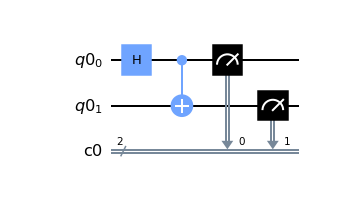

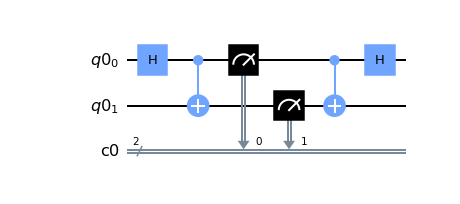

In [4]:
from IPython.display import Image, display

simple_test()
display(Image(filename='Alice_qc.png'))
display(Image(filename='Bob_qc.png'))


In [5]:
def test_protocol(bit_string, delta_t, noise_model, entanglement_ratio):
    # Alice's preparation
    alice = Alice(bit_string, delta_t)
    circuits = alice.prepare_states()

    # Initialize Bob and measure states
    bob = Bob(circuits, delta_t, noise_model, entanglement_ratio=entanglement_ratio)
    measured_bit_string, _, _ = bob.measure_states()
    
    return measured_bit_string

In [6]:
def accuracy_graph(bit_string, delta_ts, entanglement_ratios):
    # Create the noise model
    noise_model = NoiseModel()
    error = amplitude_damping_error(0.15)  # 15% chance of photon loss
    noise_model.add_all_qubit_quantum_error(error, ['id', 'rx', 'x'])
    error_2 = depolarizing_error(0.05, 2)  # 5% chance of depolarizing error
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    accuracy_results = {}

    total_iterations = len(entanglement_ratios) * len(delta_ts)
    progress_bar = tqdm(total=total_iterations, ncols=70, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

    for ratio in entanglement_ratios:
        accuracy_results[ratio] = []
        for delta_t in delta_ts:
            output_bit_string = test_protocol(bit_string, delta_t, noise_model, ratio)
            accuracy = sum(1 if i == j else 0 for i, j in zip(bit_string, output_bit_string)) / len(bit_string)
            accuracy_results[ratio].append(accuracy)
            progress_bar.update()

    progress_bar.close()
    return accuracy_results

In [7]:
def plot_graph(accuracy_results, delta_ts):    
    # Plotting the results
    plt.figure(figsize=(10,6))
    for ratio, accuracies in accuracy_results.items():
        plt.plot(delta_ts, accuracies, label=f'Ratio: {ratio}')
    plt.xlabel('Delta t')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Quantum Communication Protocol with Different Parameters')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
bit_string = '1101010011000010'
entanglement_ratios = [0.3, 0.4, 0.5, 0.6, 0.7]
delta_ts = range(1, 101, 5)

accuracy_results = accuracy_graph(bit_string, delta_ts, entanglement_ratios)


100%|████████████████████████████████████████████████████████| 100/100


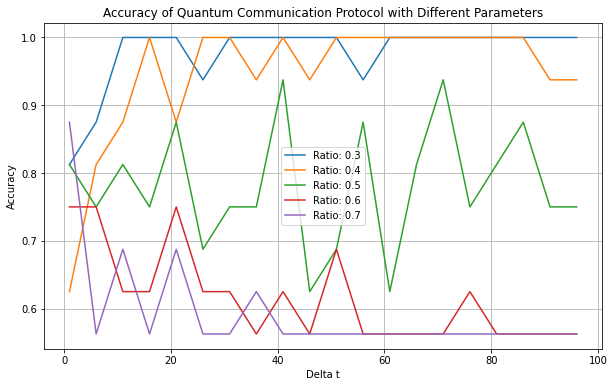

In [9]:
plot_graph(accuracy_results, delta_ts)

In [10]:
def average_accuracy_graph(bit_string, delta_ts, entanglement_ratios, num_runs=10):
    # Initialize an empty results dictionary
    average_results = {}
    for ratio in entanglement_ratios:
        average_results[ratio] = [0]*len(delta_ts)

    # Run accuracy_graph() multiple times and add up the results
    for _ in range(num_runs):
        results = accuracy_graph(bit_string, delta_ts, entanglement_ratios)
        for ratio in entanglement_ratios:
            for i in range(len(delta_ts)):
                average_results[ratio][i] += results[ratio][i]

    # Divide by num_runs to get the average
    for ratio in entanglement_ratios:
        for i in range(len(delta_ts)):
            average_results[ratio][i] /= num_runs

    return average_results

In [11]:
num_runs = 10
average_results = average_accuracy_graph(bit_string, delta_ts, entanglement_ratios, num_runs)

100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100
100%|████████████████████████████████████████████████████████| 100/100


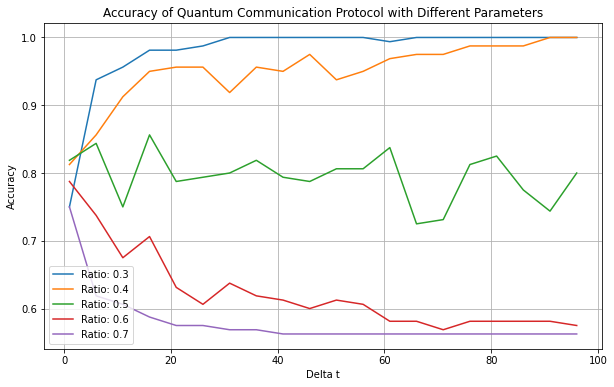

In [12]:
plot_graph(average_results, delta_ts)